To do (updated Nov 29):
- use rotation curves (to be provided by Addy) for bulk velocity $\bar{v}(r)$
- figure out the best way to use rotation curves to calculate the escape velocity. Currently I'm using the gravitational potential $\Phi_\text{total} = \Phi_\text{bulge} + \Phi_\text{disk}$
- test max halo distance value

Nov 29:
- normalization factor doesn't give $f_b(v_b)$ integral of 1 for small radii, this seems to be associated with normalization factors that are negative (which is possible for small enough $v_\text{esc}$ i.e. at small radii - see below for analytic form of normalization factor), for which the distribution function is being set to zero anyway, so I think this is ok
- choose appropriate energy array on flux calculation/plot: currently using $m_\chi \pm 5\epsilon m_\chi$ where $\epsilon$ is the resolution factor
- max halo distance was returning a **smaller** number for the line of sight integral for a larger radius; seems to be a numerical issue due to integrating over such small numbers; doing a unit conversion before the integral (resulting in bigger numbers) seems to fix the issue.

Nov 28:
- based on https://galprop.stanford.edu/download/manuals/galprop_v54.pdf (see page 11), I think the GALPROP angular data is being used correctly, for example for galactic latitude $b$, the $i$th value in the array is given by:
  $$b_i = \texttt{CRVAL2} + i*\texttt{CDELT2}$$
such that the **starting value** is the array is $\texttt{CRVAL2}$

Nov 25:
- added $\Phi_\text{total} = \Phi_\text{bulge} + \Phi_\text{disk}$ potentials to calculate baryon density $\rho_b$ for escape velocity $v_\text{esc}$ - *this seems to overestimate the amount of mass, giving a higher $v_\text{esc}$ than expected*

In [1]:
import sys
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import cumtrapz
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import pandas as pd
from astropy.io import fits
from astropy import constants as const
from astropy import units as u
import bisect
import time


# constants & data import

In [2]:
# natural & conversion constants
c = 2.998e8 # speed of light [m/s]
G = 6.674e-11 # [N m^2 kg^-2]
hbar = 6.582e-16 # [eV s]
GeV_per_kg = 5.625e26
cm_per_kpc = 3.086e21


# constants
rho_s = 0.51 # DM radial scale for MW NFW profile [GeV/cm^3]; https://arxiv.org/abs/1906.08419
r_s = 8.1 # DM radial scale for MW NFW profile [kpc]; https://arxiv.org/abs/1906.08419
M_sun = 2e30 # [kg]
M_bulge = 1.5e10 * M_sun # [kg]
c_bulge = 0.6 # bulge scale radius [kpc]
M_disk = 7e10 * M_sun # [kg]
b_disk = 4 # disk scale radius [kpc]
R_odot = 8.0 # Sun's distance from centre of MW [kpc]
M_SMBH = 4.154e6 * M_sun # [kg]
vbar = 220 # [km/s]


# dictionaries
# m_N_MeV = {'He4': 3758.26, 'C12': 11274.78, 'N14': 13153.91, 'O16': 15033.04}
nuc_info = {'He4': [3758.26, 0.0], 'C12': [11274.78, 0.0], 'N14': [13153.91, 0.0], 'O16': [15033.04, 0.0]}


# importing C12 and O16 data: excitation energies and GT strengths
C12_data = '{}_{}_{}.txt'.format('C12', nuc_info['C12'][0], nuc_info['C12'][1])
O16_data = '{}_{}_{}.txt'.format('O16', nuc_info['O16'][0], nuc_info['O16'][1])
Cdf = pd.read_csv(C12_data, sep='\t', names=['E_gamma [MeV]', 'GT strength'], skiprows=1)
Odf = pd.read_csv(O16_data, sep='\t', names=['E_gamma [MeV]', 'GT strength'], skiprows=1)
CdEs, OdEs = Cdf['E_gamma [MeV]'], Odf['E_gamma [MeV]']
dEs_dict = {'C12': Cdf['E_gamma [MeV]'], 'O16': Odf['E_gamma [MeV]']}
GTs_dict = {'C12': Cdf['GT strength'], 'O16': Odf['GT strength']}


# optimal m_chi values
def read_optimal_m_chis(nucleus):
    df = pd.read_csv('optimal_m_chis_{}.txt'.format(nucleus), \
                     sep='\t', \
                     names=['Nuclear excitation energy [MeV]', 'Optimal DM mass [MeV]'], \
                     skiprows=1)
    return [df['Nuclear excitation energy [MeV]'], df['Optimal DM mass [MeV]']]
m_chis_dEs_C12 = read_optimal_m_chis('C12')
dEs_C12, m_chis_C12 = m_chis_dEs_C12[0], m_chis_dEs_C12[1]
m_chis_dEs_O16 = read_optimal_m_chis('O16')
dEs_O16, m_chis_O16 = m_chis_dEs_O16[0], m_chis_dEs_O16[1]


In [3]:
CdEs == dEs_C12

0      True
1      True
2      True
3      True
4      True
       ... 
113    True
114    True
115    True
116    True
117    True
Length: 118, dtype: bool

# GALPROP density data

- https://galprop.stanford.edu/download/manuals/galprop_v54.pdf
- https://fits.gsfc.nasa.gov/users_guide/usersguide.pdf
- https://astropy4cambridge.readthedocs.io/en/latest/_static/Astropy%20-%20Handling%20FITS%20files.html

In [4]:
hdul_CO = fits.open('massdensity_CO.fits')
hdul_CO[0].header

SIMPLE  =                    T / Written by IDL:  Mon Aug 17 03:48:15 2015      
BITPIX  =                  -32 /                                                
NAXIS   =                    3 /                                                
NAXIS1  =                  720 /                                                
NAXIS2  =                  360 /                                                
NAXIS3  =                    9 /                                                
EXTEND  =                    T /                                                
CRVAL1  =             0.250000 /                                                
CDELT1  =             0.500000 /                                                
CRPIX1  =              1.00000 /                                                
CTYPE1  = 'GLON    '           /                                                
CRVAL2  =             -89.7500 /                                                
CDELT2  =             0.5000

In [5]:
# radial data
hdul_CO[1].data

FITS_rec([( 0.       ,  1.4760095), ( 1.4760095,  3.5248926),
          ( 3.5248926,  5.5203085), ( 5.5203085,  7.5050545),
          ( 7.5050545,  9.5      ), ( 9.5      , 11.5      ),
          (11.5      , 13.5      ), (13.5      , 15.5      ),
          (15.5      , 50.       )],
         dtype=(numpy.record, [('Rmin', '>f4'), ('Rmax', '>f4')]))

In [6]:
data = hdul_CO[0].data # [kg/cm^3] density data, see below for explanation
"""
density data: hdul_CO[0].data[r bin index, b index, l index]
    r bin index: 0 through 8 (axis 3)
    b index: 0 through 359 (axis 2)
    l index: 0 through 719 (axis 1)
    example: hdul_CO[0].data[8, 359, 719]
    gives the density in kg/cm^3 for a given (r, b, l)
"""
bins = hdul_CO[1].data # [kpc] radial bin boundaries
r_bins = [bins[0][0]] # r bin smallest value
for i, j in bins: # creating r bins from GALPROP increments
    r_bins.append(j)
r_bins
# note GALPROP specifies Rsun = 8.5 kpc, Vsun = 220 km/s 

[0.0, 1.4760095, 3.5248926, 5.5203085, 7.5050545, 9.5, 11.5, 13.5, 15.5, 50.0]

In [7]:
# creating b and l arrays
b_len, l_len = hdul_CO[0].header['NAXIS2'], hdul_CO[0].header['NAXIS1'] # length of b, l arrays
b_crval, l_crval = hdul_CO[0].header['CRVAL2'], hdul_CO[0].header['CRVAL1'] # central values of b,l
b_delta, l_delta = hdul_CO[0].header['CDELT2'], hdul_CO[0].header['CDELT1'] # increments for b, l

In [8]:
bs = list(np.arange(b_crval, b_crval + b_len*b_delta, b_delta))
ls = list(np.arange(l_crval, l_crval + l_len*l_delta, l_delta))

In [9]:
len(bs)

360

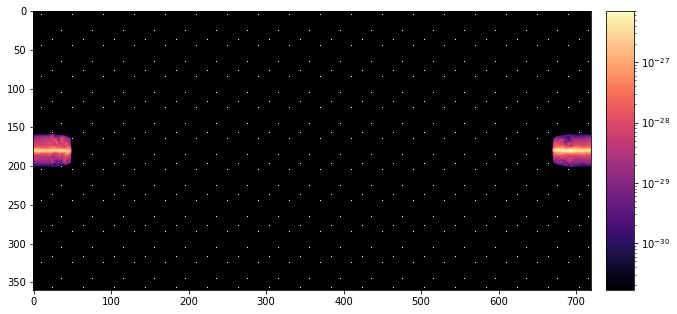

In [10]:
fig = plt.figure(figsize = (10,15))
ax = plt.axes()
im = ax.imshow(hdul_CO[0].data[1], cmap='magma', norm=matplotlib.colors.LogNorm())
a, b = 0.02, 0.04
cax = fig.add_axes([ax.get_position().x1 + a, ax.get_position().y0, b, ax.get_position().height])
plt.colorbar(im, cax=cax)

# radius $r(s, b, l)$ & maximum line of sight distance $s_\text{max}$

<center>
    <img src="lineOfSight.PNG" width=500>
</center>

$$\cos\psi = \cos(l)\cos(b)$$

$$  \begin{align}
r &= \sqrt{R_\odot^2 + s^2 - 2 R_\odot s \cos \psi} \\
&= \sqrt{R_\odot^2 + s^2 - 2 R_\odot s \cos b \cos l} 
\end{align} $$
<!-- $$ r = \sqrt{R_\odot^2 + s^2 - 2 R_\odot s \cos \psi} $$ -->

$$ s_\text{max} = (R_\text{halo}^2 - R_\odot^2 \sin^2\psi)^{1/2} + R_\odot \cos\psi $$

In [11]:
def R(s, b, l):
    """
    returns: [kpc] radius, as a function of s, b, l
    ********
    s: [kpc] line of sight coordinate
    b: [degrees] galactic latitude
    l: [degrees] galactic longitude
    """
    psi = np.arccos( np.cos(np.radians(b)) * np.cos(np.radians(l)) ) # [radians]
    return np.sqrt(R_odot**2 + s**2 - 2 * R_odot * s * np.cos(psi)) # [kpc]


def s_max(b, l, R_halo):
    """
    returns: [kpc] maximum value of line-of-sight coordinate, as a function of angles b, l, and the halo scale R_halo
    ********
    b: [degrees] galactic latitude
    l: [degrees] galactic longitude
    R_halo: [kpc] MW halo radius - chosen by user
    """
    psi = np.arccos( np.cos(np.radians(b)) * np.cos(np.radians(l)) ) # [radians]
    return (np.sqrt(R_halo**2 - R_odot**2 * (np.sin(psi))**2) + R_odot * np.cos(psi)) # [kpc]


Text(0.5, 1.0, 'radial coordinate as function of line of sight')

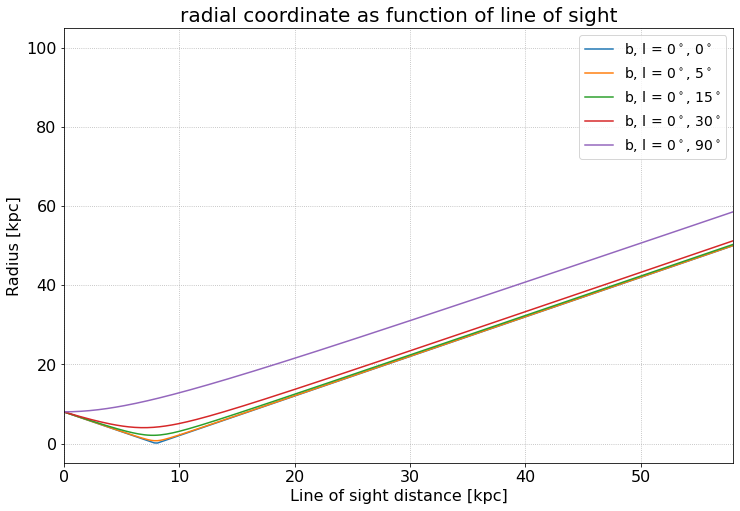

In [161]:
R_max = 50.0
plt.figure(figsize = (12, 8))
plt.grid(which = 'both', linestyle = 'dotted')
plt.xticks(size = 16); plt.yticks(size=16);
plt.xlabel(r'Line of sight distance [kpc]', fontsize = 16); plt.ylabel(r'Radius [kpc]', fontsize = 16)
plt.xlim(0, s_max(0, 0, R_max))
for deg in [0, 5, 15, 30, 90]:
    bb = 0 # in galactic plane
    ll = deg
    S_MAX = s_max(bb, ll, 2 * R_max)
    # print(S_MAX)
    ss = np.linspace(0, S_MAX, 400)
    rs = list(map(lambda s: R(s, bb, ll), ss))
    plt.plot(ss, rs, label="b, l = {}$^\circ$, {}$^\circ$".format(bb, ll))
plt.plot()
plt.legend(fontsize=14)
plt.title('radial coordinate as function of line of sight', fontsize = 20)


# density

The mass density of particle $N \in \{\text{C12}, \text{O16}\}$ is related to the mass density of CO by
$$ \rho_N (r, b, l) = m_N \frac{\rho_\text{CO}(r, b, l)}{m_\text{CO}}. $$

In [13]:
def densityInterpolate(r, b, l):
    """
    returns: [kg/cm^3] density at a given radius, interpolated for values (b, l) from gridded data
    """
    r_index = bisect.bisect(r_bins, r) - 1 # find radial bin index
    values_grid = hdul_CO[0].data[r_index] # reduces 3D grid (r, b, l) to 2D (b, l)
    interpolating_fx = RegularGridInterpolator((bs,ls), values_grid)
    return interpolating_fx(np.array([b, l]))


def densityLOS(particle, s, b, l):
    """
    returns: [GeV/cm^3] mass density as a function of line of sight distance
    **********
    particle: 'DM', 'He4', 'C12', 'N14', 'O16', 'CO', 'Fe57'
    s: [kpc] line of sight distance
    b: [degrees] galactic latitude
    l: [degrees] galactic longitude

    constants:
    rho_s = 0.51 # DM radial scale at (r = R_odot) for MW NFW profile [GeV/cm^3]; https://arxiv.org/abs/1906.08419

    conversion factors:
    GeV_per_kg = 5.625e26
    """
    m_N_MeV = {'He4': 3758.26, 'C12': 11274.78, 'N14': 13153.91, 'O16': 15033.04}
    r = R(s, b, l) # [kpc] # finds radius for a given (s, b, l) in order to find the dispersion at those coordinates
    if r > r_bins[-1]: # if radius is beyond what is provided by GALPROP, return zero
        #print('no baryon density for this radius, try reducing R_max')
        return 0
    
    rho_b = m_N_MeV[particle] * densityInterpolate(r, b, l)[0] / (m_N_MeV['C12'] + m_N_MeV['O16']) * GeV_per_kg # [GeV/cm^3]
    rho_DM = rho_s / ( (r/r_s) * (1 + r/r_s)**2 ) # [GeV/cm^3]
    return(rho_b, rho_DM)


def density(particle, r, b, l):
    """
    returns: [GeV/cm^3] mass density as a function of radius from galactic centre
    **********
    particle: 'DM', 'He4', 'C12', 'N14', 'O16', 'CO', 'Fe57'
    r: [kpc] radius from galactic centre
    b: [degrees] galactic latitude
    l: [degrees] galactic longitude
    """
    m_N_MeV = {'He4': 3758.26, 'C12': 11274.78, 'N14': 13153.91, 'O16': 15033.04}
    rho_DM = rho_s / ( (r/r_s) * (1 + r/r_s)**2 ) # [GeV/cm^3]
    if r > r_bins[-1]: # if radius is beyond what is provided by GALPROP, return zero
        #print('no baryon density for this radius, try reducing R_max')
        rho_b = 0
        return(rho_b, rho_DM)    
    
    rho_b = m_N_MeV[particle] * densityInterpolate(r, b, l)[0] / (m_N_MeV['C12'] + m_N_MeV['O16']) * GeV_per_kg # [GeV/cm^3]
    return(rho_b, rho_DM)
        

In [14]:
hdul_CO[0].data[1,180,0]

1.869413e-27

In [15]:
density('O16', R_odot*7, 0.25, 0.25)

(0, 0.0011779345131906454)

Text(0.5, 1.0, 'dm density as function of line of sight')

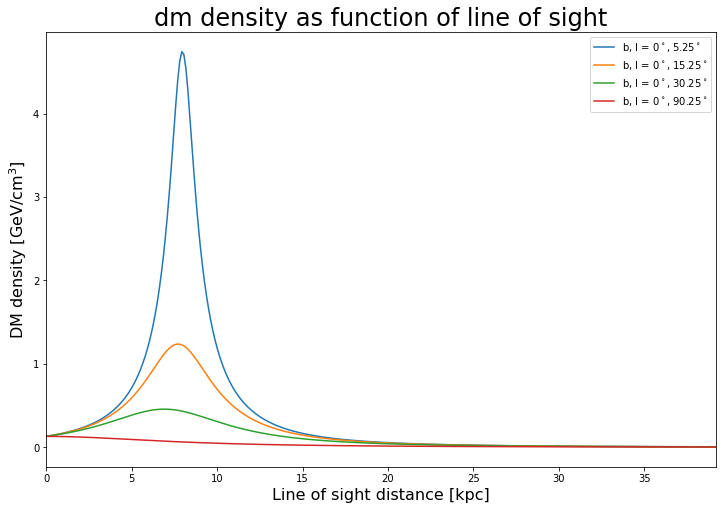

In [16]:
N_odot = 5 # sets max radius, r_max = N_odot * R_odot

plt.figure(figsize = (12, 8))
plt.xlabel(r'Line of sight distance [kpc]', fontsize = 16)
plt.ylabel(r'DM density [GeV/cm$^3$]', fontsize = 16)
plt.xlim(0, s_max(b_crval, l_crval + 90, N_odot * R_odot))
for deg in [5, 15, 30, 90]:#, 45]:
    bb = 0
    ll = l_crval + deg
    S_MAX = s_max(bb, ll, N_odot * R_odot)
    ss = np.linspace(0, S_MAX, 400)
    rho_DM = list(map(lambda s:densityLOS('C12', s, bb, ll)[1], ss))
    plt.plot(ss, rho_DM, label="b, l = {}$^\circ$, {}$^\circ$".format(bb, ll))
plt.plot()
plt.legend()
plt.title('dm density as function of line of sight', fontsize = 24)


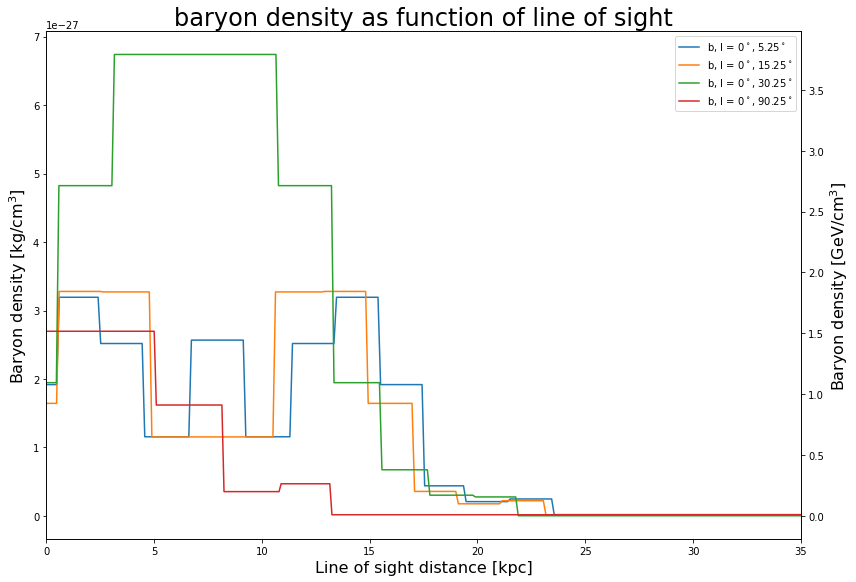

In [17]:
N_odot = 5 # sets max radius, r_max = N_odot * R_odot
fig, ax1 = plt.subplots(figsize = (12, 8))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel(r'Line of sight distance [kpc]', fontsize = 16)
ax1.set_ylabel(r'Baryon density [kg/cm$^3$]', fontsize = 16)
ax2.set_ylabel(r'Baryon density [GeV/cm$^3$]', fontsize = 16)  # we already handled the x-label with ax1
ax2.set_xlim(0,35)

for deg in [5, 15, 30, 90]:#, 45]:
    bb = 0
    ll = l_crval + deg
    S_MAX = s_max(bb, ll, N_odot * R_odot)
    ss = np.linspace(0, S_MAX, 400)
    rho_b_kg = list(map(lambda s:densityLOS('C12', s, bb, ll)[0] * 1/GeV_per_kg, ss))
    rho_b_GeV = list(map(lambda s:densityLOS('C12', s, bb, ll)[0], ss))
    ax1.plot(ss, rho_b_kg, label="b, l = {}$^\circ$, {}$^\circ$".format(bb, ll))
    ax2.plot(ss, rho_b_GeV, label="b, l = {}$^\circ$, {}$^\circ$".format(bb, ll), color='black', linestyle='')
    ax1.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('baryon density as function of line of sight', fontsize = 24);

# velocity dispersions $\sigma(r, \psi)$

In [18]:
def vDispersion(r):
    """
    returns: 3D velocity dispersion [km/s]
    **********
    particle: 'DM', 'He4', 'C12', 'N14', 'O16', 'Fe57'
    b: galactic latitude [degrees] in GALPROP convention
    l: galactic longitude [degrees] in GALPROP/standard convention
    """
    # r = R(s, b, l) # [kpc] # finds radius for a given (s, b, l) in order to find the dispersion at those coordinates
    # if r > r_bins[-1]: # if radius is beyond what is provided by GALPROP, return error
    #     print('no baryon density for this radius, try reducing R_max')
    #     return
    # print(r)  
    # if particle == 'DM':
    #     """
    #     dispersion function taken from 2111.03076 Figure 1: r in units kpc, velocity dispersion in units km/s
    #     """
    #     return (-42.4 * np.log10(r) + 382.2) # [km/s]
    # # elif particle == 'He4': # copy for each potential target
    #     # return function of r
    # elif particle in ['He4', 'C12', 'N14', 'O16', 'CO', 'Fe57']:
    #     return 10 # [km/s]

    disp_b = 10 # [km/s]
    disp_DM = (-42.4 * np.log10(r) + 382.2) # [km/s]
    
    return [disp_b, disp_DM]
        

# $v_\text{esc}(r)$

- Compare $v_\text{esc}$ with Figures 2 and 3 of https://ui.adsabs.harvard.edu/abs/2021A%26A...649A.136K/abstract (try https://www.aanda.org/articles/aa/pdf/2018/08/aa33748-18.pdf or https://pure.rug.nl/ws/portalfiles/portal/196810757/aa38777_20.pdf)
- also see https://www.aanda.org/articles/aa/pdf/2018/08/aa33748-18.pdf

The total mass enclosed in cylinder of radius $r$ and height $z$ is
\begin{align}
m_\text{CO} &= \int dV \rho_\text{CO}(r) \\
&= \int_{-z/2}^{z/2} \int_0^{2\pi} \int_0^r \rho_\text{CO}(r')~r'~dr'~d\theta~dz' \\
&= 2\pi z \int_0^r \rho_\text{CO}(r')~r'~dr'. \\
\end{align}

The total mass enclosed in a sphere of radius $r$ is
\begin{align}
    m_b &= \int dV \rho_b(r) \\
    &= 4\pi \int_0^r \rho_b(r') ~ r'^2 ~ dr'
\end{align}

We model the baryonic density as gravitational potentials describing the bulge and disk, $\Phi_\text{bulge} + \Phi_\text{disk}$ \cite{Strigari:2009zb, Pato:2012fw}.
The potential of the bulge is spherically symmetric,
\begin{equation}
    \Phi_\text{bulge}(r) = -\frac{G M_\text{bulge}}{r + c_0},
\end{equation}
where the bulge mass is $M_\text{bulge} = 1.5\times 10^{10} ~ \text{M}_{\odot}$ and the bulge scale radius is $c_0 = 0.6 ~ \text{kpc}$.
The potential of the disk is approximated as spherical,
\begin{equation}
    \Phi_\text{disk}(r) = -\frac{G M_\text{disk}}{r} \left[ 1 - e^{-r/b_\text{disk}} \right],
\end{equation}
with disk mass $M_\text{disk} = 7 \times 10^{10} ~ \text{M}_\odot$ and disk scale radius $b_\text{disk} = 4 ~ \text{kpc}$.

The baryon density is then given by the Poisson equation
\begin{equation}
    \nabla^2 \Phi = 4 \pi G \rho_b(r).
\end{equation}

\begin{align}
    \nabla^2 \Phi &= \nabla^2 \left[ -\frac{G M_\text{bulge}}{r + c_0} + -\frac{G M_\text{disk}}{r} \left[ 1 - e^{-r/b_\text{disk}} \right] \right] \\
    &= \frac{1}{r^2} \frac{\partial}{\partial r} \Bigg( r^2 \frac{\partial}{\partial r} \left[ -\frac{G M_\text{bulge}}{r + c_0} + -\frac{G M_\text{disk}}{r} \left[ 1 - e^{-r/b_\text{disk}} \right] \right] \Bigg) \\
\end{align}

\begin{align}
    \rho_b(r) &= \frac{1}{4\pi G} \nabla^2 \Phi \\
    &= \frac{c_0 M_\text{bulge}}{2\pi r(c_0 + r)^3} + \frac{M_\text{disk} e^{-r/b_\text{disk}}}{4 \pi b^2 r}
\end{align}

In [19]:
rho_r_data = pd.read_csv('massDensity_CO_r.csv', names=['Radius [kpc]', 'Mass density [kg/m^3]'], skiprows=1)
rho_radius, rho_rho = rho_r_data['Radius [kpc]'], rho_r_data['Mass density [kg/m^3]']


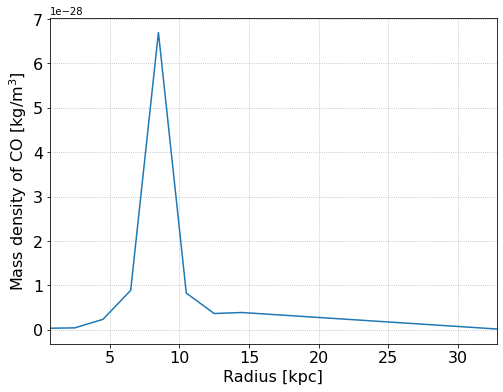

In [20]:
plt.figure(figsize = (8,6))
plt.grid(which = 'both', linestyle = 'dotted')
plt.xticks(size = 16); plt.yticks(size=16);
plt.xlabel(r'Radius [kpc]', fontsize=16); plt.ylabel(r'Mass density of CO [kg/m$^3$]', fontsize=16)
plt.xlim(rho_radius[0], rho_radius.iat[-1])
plt.plot(rho_radius, rho_rho)


In [21]:
def M_CO(r, z):
    """
    *** THIS FUNCTION HAS TO BE UPDATED TO INCLUDE ALL BARYON MASS, NOT JUST CO ***
    ****** NOTE: this function has a very high integration error ******
    returns: [kg] CO mass within radius r, height z assuming CYLINDRICAL distribution
    ****************
    r: [kpc]
    z: [kpc] height of cylinder; |z| < 1 kpc
    """
    def f(R):
        return R * np.interp(R, rho_radius, rho_rho) # [kg/m^3 * kpc^2]
    result = quad(f, 0, r)
    # print(result)
    mass_kg = 2*np.pi * z * result[0] * (cm_per_kpc / 100)**3 # [kg]
    return  mass_kg


def M_b(r):
    """
    returns: [kg] baryon mass within radius r
    assumes baryon potential given by bulge + disk
    """
    def f(R):
        return R**2 * ( (c_bulge * M_bulge) / (2 * np.pi * R * (c_bulge + R)**3) \
                       + (M_disk * np.exp(-R / b_disk)) / (4 * np.pi * b_disk**2 * R) ) # [kg/m^3 * kpc^2]
    result = quad(f, 0, r)
    mass_kg = 4 * np.pi * result[0] # [kg]
    return mass_kg


def M_DM(r):
    """
    returns: [kg] DM mass of MW within radius r_esc [kpc]
    r: [kpc]
    """
    def f(R):
        """
        returns: [GeV/cm^3 * kpc^3] DM mass
        """
        return 2*np.pi * 2 * R**2 * rho_s / ( (R/r_s) * (1 + R/r_s)**2 ) # [GeV/cm^3] * kpc^3
    # convert to kg
    mass_kg = quad(f, 0, r)[0] * cm_per_kpc**3 * 1/GeV_per_kg # [kg]

    return mass_kg


def M_MW(r):
    z = 1 # [kpc]
    # M_total = M_CO(r_esc, z) + M_DM(r_esc) # [kg]
    M_total = M_b(r) + M_DM(r) # [kg]
    mass_odot = M_total / M_sun # [solar masses]
    # print("{:2.2e} solar masses".format(mass_odot))
    # print("MW galaxy should be approximately 1.2e12 solar masses")
    return M_total


def v_esc(r):
    """
    returns: [km/s] escape velocity as function of radius
    *** CURRENTLY ONLY ASSUMES DM MAKING UP MASS ***
    """
    M = M_MW(r) # [kg]
    # M = 1.2e12 * M_sun
    # convert r from kpc to m
    # convert v_esc to km/s
    return 3 * np.sqrt(2 * G * M / (r * cm_per_kpc / 100)) / 1000 # [km/s]

# M_CO(40, 1)
# M_DM(40)
# M_MW(40)

In [22]:
v_esc(5)

843.087629128677

# $v_\chi$ integral

## Normalization

The distribution functions are normalized such that
\begin{align}
1 &= \int_0^{v_\text{esc}} f(v) d^3 v \\
&= \int_0^{2\pi} d\phi \int_0^\pi d\theta ~\sin\theta \int_0^{v_\text{esc}(r)} dv ~v^2 f(\vec{v})
\end{align}

For the DM distribution,
\begin{equation}
f_\chi(\vec{v}_\chi) = \frac{1}{\mathcal{N}_\chi(r)} \left( \frac{1}{2\pi (\sigma_\chi(r))^2} \right)^{3/2} \exp\left[ -\frac{\vec{v}_\chi^2}{2(\sigma_\chi(r))^2} \right]
\end{equation}

The integral gives analytic solution
\begin{align}
\mathcal{N}_\chi(r) &= 4\pi \left[ 2\pi (\sigma_b(r))^2 \right]^{-3/2} \times \Bigg( \sqrt{\frac{\pi}{2}}  (\sigma_\chi(r))^3 ~\text{erf}\left[ \frac{v_\text{esc}(r)}{\sqrt{2} \sigma_\chi(r)} \right] - (\sigma_\chi(r))^2 v_\text{esc}(r) \exp\left[ \frac{-(v_\text{esc}(r))^2}{2(\sigma_\chi(r))^2} \right] \Bigg)
\end{align}

In [23]:
def norm_chi(V_ESC, sigma_chi):
    """
    DM normalization factor, checked with function Int_f_chi(s, b, l)
    """
    norm = (2*np.pi * sigma_chi**2)**(-3/2) * (4 * np.pi) \
    * ( np.sqrt(np.pi / 2) * sigma_chi**3 * scipy.special.erf(V_ESC / (np.sqrt(2) * sigma_chi) ) \
       - sigma_chi**2 * V_ESC * np.exp(-V_ESC**2 / (2 * sigma_chi**2)))
    return norm


def Int_v_chi(m_chi, m_N, deltaE, r, v_i):
    """
    returns: integral of DM velocity distribution [MeV^-1 km s^-1]
    **********
    deltaE: excitation energy [MeV]
    m_chi: DM mass [MeV] 
    m_N: nucleus mass [MeV]
    v_i: nucleus velocity [km/s]
    r: radius from galactic centre [kpc]
    """
    if m_chi < 0:
        return 0
    
    V_I = v_i / (c/1000) # convert from km/s to unitless
    if (deltaE - m_chi - (1/2) * m_N * V_I**2) < 0: # process is not possible
        return 0

    v_chi_plus = np.sqrt( (2 * (deltaE - m_chi - (1/2) * m_N * V_I**2) ) / (m_chi) ) * (c/1000) # [km/s]
    V_ESC = v_esc(r) # [km/s]
    if v_chi_plus > V_ESC:
        return 0
        
    V_CHI = v_chi_plus / (c/1000) # convert from [km/s] to [unitless]        
    E_chi = ( m_chi + (1/2) * m_chi * V_CHI**2 ) # [MeV]
    sigma_chi = vDispersion(r)[1] # [km/s]
    norm = norm_chi(V_ESC, sigma_chi)

    return ( (1 / norm) * (1 / E_chi) * v_chi_plus * np.exp(-v_chi_plus**2 / (2 * sigma_chi**2)) ) # [MeV^-1 km/s]


In [24]:
# v_chi_plus(m_N = nuc_info['O16'][0], m_chi = 16.73, deltaE = 16.732241, v_i = 163/(c/1000))

In [25]:
# v_chi_plus(m_N = nuc_info['O16'][0], m_chi = 16.72997316197439, deltaE = 16.732241, v_i = 163/(c/1000))

In [26]:
tic = time.time()
Int_v_chi(16.73, nuc_info['O16'][0], 16.732241, 16, 163.5)
# print(time.time()-tic)

13.217152516536697

In [27]:
# tic = time.time()
# Int_v_chi_E(16.73, nuc_info['O16'][0], 16.732241, 16, 163.5)
# print(time.time()-tic)

In [28]:
Int_v_chi(16.72, nuc_info['O16'][0], 16.732241, 17.85729552469265, 382.4)

14.407847276922597

In [29]:
Int_v_chi(16.73, nuc_info['O16'][0], 16.732241, 16, 382.4)

0

# $v_b$ integral

## $v_b$ bounds

From $V_\chi^+ (v_N)$ we can find the bounds for $v_N$ that will give a nonzero answer to further narrow down the integration range and get a more accurate result.
$$ V_\chi^+ (v_i) = \left[ \frac{2(\Delta E - m_\chi - \frac{1}{2}m_N v_N^2)}{m_\chi} \right]^{1/2} $$

### $v_b$ upper bound:
$$\Delta E - m_\chi - \frac{1}{2} m_N v_N^2 >0 $$
\begin{equation}
\boxed{v_N < \left[ \frac{2(\Delta E - m_\chi)}{m_N} \right]^{1/2}}
\end{equation}


### $v_b$ lower bound:
$$ \left[ \frac{2(\Delta E - m_\chi - \frac{1}{2}m_N v_N^2)}{m_\chi} \right]^{1/2} < v_\text{esc} $$
\begin{equation}
\boxed{\left[ \frac{2(\Delta E - m_\chi - \frac{1}{2}m_\chi v_\text{esc}^2)}{m_N} \right]^{1/2} < v_N}
\end{equation}

## Normalization

The distribution functions are normalized such that
\begin{align}
1 &= \int_0^{v_\text{esc}} f(v) d^3 v \\
&= \int_0^{2\pi} d\phi \int_0^\pi d\theta ~\sin\theta \int_0^{v_\text{esc}(r)} dv ~v^2 f(\vec{v})
\end{align}

For the baryon distribution **(note that the baryon velocity dispersion currently does NOT depend on radius)**,
\begin{equation}
f_b(v_b) = \frac{1}{\mathcal{N}_b(r)} \left( \frac{1}{2\pi \sigma_b^2} \right)^{3/2} \exp\left[ -\frac{\left( \vec{v}_b - \bar{v}(r) \right)^2}{2\sigma_b^2} \right]
\end{equation}

The integral gives analytic solution
\begin{align}
\mathcal{N}_b(r) &= 4\pi \left[ 2\pi \sigma_b^2 \right]^{-3/2} \frac{1}{2} \sigma_b \\
& \qquad \times \Bigg( \sqrt{2\pi}\left(\bar{v}(r)^2 + \sigma_b^2\right) ~\text{erf}\left[ \frac{\bar{v}(r)}{\sqrt{2} \sigma_b} \right] - \sqrt{2\pi}\left( \bar{v}(r)^2 + \sigma_b^2 \right) ~\text{erf} \left[ \frac{\bar{v}(r) - v_\text{esc}(r)}{\sqrt{2} \sigma_b} \right] \\
& \qquad \qquad + 2\bar{v}(r) \sigma_b \exp\left[-\frac{\bar{v}(r)^2}{2\sigma_b^2} \right] - 2\sigma_b(r) \left(\bar{v}(r) + v_\text{esc}(r) \right)\exp\left[-\frac{\left(\bar{v}(r) - v_\text{esc}(r)\right)^2}{2 \sigma_b^2} \right]\Bigg)
\end{align}

In [225]:
def v_N_integralBounds(m_N, m_chi, deltaE, V_ESC):
    """
    returns: [km/s] min and max bounds on v_N
    """
    v_N_min = np.sqrt(2 * (deltaE - m_chi - (1/2) * m_chi * (V_ESC/(c/1000))**2) / m_N) * (c/1000) # [km/s]
    v_N_max = np.sqrt(2 * (deltaE - m_chi) / m_N) * (c/1000) # [km/s]
    
    if v_N_min > V_ESC:
        v_N_min = V_ESC
    if v_N_max > V_ESC:
        v_N_max = V_ESC
    if v_N_min > v_N_max:
        print('v_N bounds make no sense!')
        
    return [v_N_min, v_N_max] # [km/s]


def norm_N(VBAR, V_ESC, sigma_b):
    norm = (2*np.pi * sigma_b**2)**(-3/2) * (4 * np.pi) \
    * (1/2) * sigma_b * (np.sqrt(2 * np.pi) * (VBAR**2 + sigma_b**2) * scipy.special.erf(VBAR / (np.sqrt(2) * sigma_b)) \
                        - np.sqrt(2 * np.pi)  * (VBAR**2 + sigma_b**2) * scipy.special.erf((VBAR - V_ESC) / (np.sqrt(2) * sigma_b)) \
                        + 2 * sigma_b**2 * VBAR * np.exp(- VBAR**2 / (2 * sigma_b**2)) \
                        - 2 * 2 * sigma_b**2 * (VBAR + V_ESC) * np.exp(- (VBAR - V_ESC)**2 / (2 * sigma_b**2)) )
    return norm


def Int_v_N(m_chi, m_N, deltaE, r):
    """
    returns: [MeV^-2 km^4 s^-4] integral of baryon velocity distribution
    **********
    deltaE: [MeV] excitation energy
    m_chi: [MeV] DM mass
    nucleus: scattering target
    r: [kpc] radius from galactic centre
    """
    if m_chi > deltaE: # process not possible
        return 0

    VBAR = vbar # [km/s]
    V_ESC = v_esc(r) # [km/s]
    if VBAR>V_ESC:
        return 0
    if (deltaE - m_chi - (1/2) * m_chi * (V_ESC/(c/1000))**2) < 0: # v_N_min expression
        return 0
    
    sigma_b = vDispersion(r)[0] # [km/s]
    norm = norm_N(VBAR, V_ESC, sigma_b)
    # ((2*np.pi * sigma_b**2)**(-3/2) * (4 * np.pi) \
    #         * (1/2) * sigma_b * (np.sqrt(2 * np.pi) * (VBAR**2 + sigma_b**2) * scipy.special.erf(VBAR / (np.sqrt(2) * sigma_b)) \
    #                              - np.sqrt(2 * np.pi)  * (VBAR**2 + sigma_b**2) * scipy.special.erf((VBAR - V_ESC) / (np.sqrt(2) * sigma_b)) \
    #                              + 2 * sigma_b**2 * VBAR * np.exp(- VBAR**2 / (2 * sigma_b**2)) \
    #                              - 2 * 2 * sigma_b**2 * (VBAR + V_ESC) * np.exp(- (VBAR - V_ESC)**2 / (2 * sigma_b**2)) ))
    if norm<0:
        return 0
        
    v_N_bounds = v_N_integralBounds(m_N, m_chi, deltaE, V_ESC)
    v_N_min, v_N_max = v_N_bounds[0], v_N_bounds[1] # [km/s], [km/s]
    
    def f(v_n):
        V_N = v_n / (c/1000) # convert from km/s to unitless
        E_N = ( m_N + (1/2) * m_N * V_N**2 ) # [MeV]
        
        integrand = ((2 * np.pi) * (1 / E_N) * sigma_b**2 * (v_n / VBAR) \
        * (np.exp(- (v_n - VBAR)**2 / (2 * sigma_b**2) ) - np.exp(- (v_n + VBAR)**2 / (2 * sigma_b**2) )) \
        * Int_v_chi(m_chi, m_N, deltaE, r, v_n)) 
        # [MeV^-1] * [km/s]^2  *  [unitless]  *  [MeV^-1 km/s]
        return integrand # [MeV^-2 * km^3/s^3]
    integral, err = quad(f, v_N_min, v_N_max)
    # return quad(f, v_N_min, v_N_max)
    return (1/norm) * integral # [MeV^-2 km^3 s^-3 * km/s] = [MeV^-2 km^4 s^-4]


In [226]:
Int_v_N(m_chi = 16.72997316197439, m_N = nuc_info['O16'][0], deltaE = 16.732241, r = 5)

9.96236117064926e-11

In [203]:
Int_v_N(m_chi = 16.731240999999994, m_N = nuc_info['O16'][0], deltaE = 16.732241, r = 5)


5.643061913910801e-31

In [197]:
Int_v_N(m_chi = 16.73, m_N = nuc_info['O16'][0], deltaE = 16.732241, r = 10)


(5.114320653731018e-08, 4.95274249433489e-09)

In [198]:
Int_v_N(m_chi = 16.722240999999993, m_N = nuc_info['O16'][0], deltaE = 16.732241, r = 10)


(4.87932292767596e-35, 1.8419175086235577e-36)

In [35]:
Int_v_N(16.73, 15044, 16.7333, 10)

5.502235229883831e-05

# line of sight $s$ integral

The numerical integrals for the baryon velocity and LOS both have very high errors associated with them (particularly LOS), such that the LOS integral may return **smaller** numbers integrating over a larger distance. This needs a solution.

$$  \begin{align}
r &= \sqrt{R_\odot^2 + s^2 - 2 R_\odot s \cos \psi} \\
&= \sqrt{R_\odot^2 + s^2 - 2 R_\odot s \cos b \cos l} 
\end{align} $$
<!-- $$ r = \sqrt{R_\odot^2 + s^2 - 2 R_\odot s \cos \psi} $$ -->

$$ s_\text{max} = (R_\text{halo}^2 - R_\odot^2 \sin^2\psi)^{1/2} + R_\odot \cos\psi $$

In [242]:
def Int_LOS(m_chi, nucleus, deltaE, b, l, R_max):
    """
    returns: [cm^-5] line of sight integral
    ********
    """
    nuc_info = {'He4': [3758.26, 0.0], 'C12': [11274.78, 0.0], 'N14': [13153.91, 0.0], 'O16': [15033.04, 0.0]}
    m_N = nuc_info[nucleus][0]
    if m_chi > deltaE:
        return 0
    psi = np.arccos( np.cos(np.radians(b)) * np.cos(np.radians(l)) ) # [radians]
    def f(s):
        r = np.sqrt(R_odot**2 + s**2 - 2 * R_odot * s * np.cos(psi)) # [kpc]
        rho = density(nucleus, r, b, l)
        disp = vDispersion(r) # km/s
        rho_b, rho_chi = rho[0], rho[1] # [GeV/cm^3], [GeV/cm^3]t
        sigma_b, sigma_chi = disp[0], disp[1] # km/s
        integrand = rho_b * rho_chi * ( (2*np.pi) * sigma_b * sigma_chi )**(-3) * Int_v_N(m_chi, m_N, deltaE, r) * 1000**2 * (c/1000)**2 * cm_per_kpc
        return integrand
        # [GeV/cm^3] * [GeV/cm^3] * [km/s]^-3 * [km/s]^-3 * [MeV^-2 km^4 s^-4] = [GeV^2 cm^-6 km^-2 s^2 MeV^-2]

    s_max = (np.sqrt(R_max**2 - R_odot**2 * (np.sin(psi))**2) + R_odot * np.cos(psi)) # [kpc]
    # print(s_max)
    # integral1, err1 = quad(f, 0, s_max/2)
    # integral2, err2 = quad(f, s_max/2, s_max)
    # integral = integral1 + integral2
    integral, err = quad(f, 0, s_max)
    # return [integral1+integral2, err1+err2]
    return [integral, err]
    # return (integral * 1000**2 * (c/1000)**2 * cm_per_kpc) # [cm^-5]
    # integrating over kpc gives a factor of kpc
    

**Below shows the LOS integral returning a larger number for a smaller radius ($4 R_\odot$) vs smaller number for larger radius ($10 R_\odot$). Plotting the function being integrated over, it's clear that the smaller radius should return a smaller number, so this discrepancy must be a numerical integration error.**

In [239]:
# tic = time.time()
Int_LOS(m_chi = 16.73, nucleus = 'O16', deltaE = 16.732241, b = bs[180], l = l_crval, R_max = R_odot*4)
# print(time.time()-tic)

3.8261848888032744e+16

In [240]:
Int_LOS(m_chi = 16.73, nucleus = 'O16', deltaE = 16.732241, b = bs[180], l = l_crval, R_max = R_odot*10)
# print(time.time()-tic)

2.54913013944764e+16

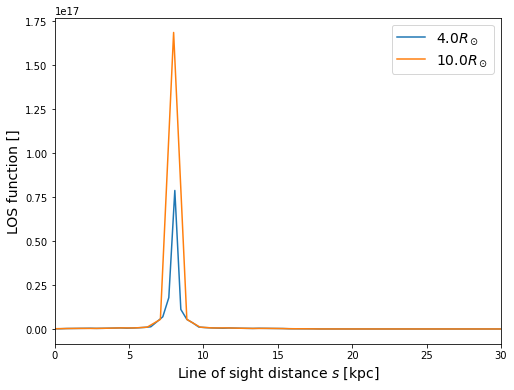

In [245]:
plt.figure(figsize=(8, 6))
plt.xlabel(r'Line of sight distance $s$ [kpc]', fontsize=14)
plt.ylabel(r'LOS function []', fontsize=14)
b = bs[180]
l = l_crval
m_chi = 16.73
m_N = nuc_info['O16'][0]
deltaE = 16.732241
psi = np.arccos( np.cos(np.radians(b)) * np.cos(np.radians(l)) ) # [radians]
for R_max in [R_odot*4, R_odot*10]:
    s_max = (np.sqrt(R_max**2 - R_odot**2 * (np.sin(psi))**2) + R_odot * np.cos(psi))
    sses = np.linspace(0, s_max, 100)
    losFunction = []
    for i in sses:
        r = np.sqrt(R_odot**2 + i**2 - 2 * R_odot * i * np.cos(psi)) # [kpc]
        rho = density('C12', r, b, l)
        disp = vDispersion(r) # km/s
        rho_b, rho_chi = rho[0], rho[1] # [GeV/cm^3], [GeV/cm^3]
        sigma_b, sigma_chi = disp[0], disp[1] # km/s
        losFunction.append( rho_b * rho_chi * ( (2*np.pi) * sigma_b * sigma_chi )**(-3) * Int_v_N(m_chi, m_N, deltaE, r) * 1000**2 * (c/1000)**2 * cm_per_kpc)
    plt.plot(sses, losFunction, label=r'{}$R_\odot$'.format(R_max/R_odot))
plt.xlim(sses[0], 30)
plt.legend(fontsize=14)


In [38]:
# tic = time.time()
# Int_LOS_disp(m_chi = 16.73, nucleus = 'O16', deltaE = 16.732241, b = 0, l = l_crval, R_max = R_odot*2)
# print(time.time()-tic)

In [243]:
Int_LOS(m_chi = 16.73, nucleus = 'O16', deltaE = 16.732241, b = 0, l = l_crval, R_max = R_odot*2)


/var/folders/3h/yy94f94d0dxc2ktk2tkt14tmf3vs4j/T/ipykernel_50031/3458608778.py:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, err = quad(f, 0, s_max)


[8.474817822664782e+16, 233170956747701.56]

In [244]:
8.474817822664782e+16/233170956747701.56

363.45940939097346

In [39]:
Int_LOS(m_chi = 16.73, nucleus = 'O16', deltaE = 16.732241, b = 0, l = l_crval, R_max = R_odot*2)


5.3438743815051864e+16

In [40]:
Int_LOS(m_chi = 16.73, nucleus = 'O16', deltaE = 16.732241, b = 0, l = l_crval, R_max = R_odot*4)


3.723603864507819e+16

In [41]:
Int_LOS(m_chi = 16.73, nucleus = 'O16', deltaE = 16.732241, b = 0, l = l_crval, R_max = R_odot*6)


2.578711591370615e+17

In [42]:
Int_LOS(m_chi = 16.72997316197439, nucleus = 'O16', deltaE = 16.732241, b = b_crval, l = l_crval, R_max = R_odot*2)


90914699508823.8

In [43]:
Int_LOS(m_chi = 16.73, nucleus = 'O16', deltaE = 16.732241, b = 0, l = l_crval, R_max = 50)


8.195421109647037e+16

In [44]:
Int_LOS(m_chi = m_chis_C12[0], nucleus = 'C12', deltaE = dEs_C12[0], b = 0, l = l_crval, R_max = 50)


1.2568052476829034e+24

# $R_\epsilon(E-E_\gamma)$

$$ \frac{dN^{i\chi}}{dE_\gamma} = \delta(\Delta E - E_\gamma),$$
for true gamma ray energy $E_\gamma$.
$$ R_\epsilon(E-E_\gamma) \approx \frac{1}{\sqrt{2\pi\epsilon^2 E_\gamma^2}} \exp \left[ -\frac{(E-E_\gamma)^2}{2\epsilon^2 E_\gamma^2} \right]$$

\begin{align}
\int dE_\gamma ~\frac{dN^{i\chi}}{dE_\gamma} R_\epsilon(E-E_\gamma) &= \int dE_\gamma ~\delta(\Delta E - E_\gamma) ~R_\epsilon(E-E_\gamma) \\
&= R_\epsilon(E-\Delta E) \\
&= \frac{1}{\sqrt{2\pi\epsilon^2 (\Delta E)^2}} \exp \left[ -\frac{(E-\Delta E)^2}{2\epsilon^2 (\Delta E)^2} \right]
\end{align}

In [45]:
def R_epsilon(epsilon, E, deltaE):
    """
    returns gaussian function in units [MeV^-1]
    ********
    epsilon:
    E: observed photon energy [MeV]
    E_gamma: true photon energy [MeV]
    """
    return (np.sqrt(2 * np.pi) * epsilon * deltaE)**(-1) * np.exp(-(E - deltaE)**2 / (2 * epsilon**2 * deltaE**2)) # [MeV^-1]


# flux
To do (updated Nov 21):
- choose appropriate energy array for flux calculation/plot
- find experimental data for comparison
- solid angle integration

In [46]:
def flux_noConv(g_chi, m_chi, nucleus, b, l, R_max, epsilon):
    """
    returns: differential flux in [cm^-2 s^-1 (sr^-1) MeV^-1]
    **********
    g_chi: [MeV^-1]
    E: observed photon energy [MeV]
    """
    g_A = 1.27 # [unitless]
    nuc_info = {'He4': [3758.26, 0.0], 
                'C12': [11274.78, 0.0], 
                'N14': [13153.91, 0.0], 
                'O16': [15033.04, 0.0]} # mass [MeV], spin
    fluxes, flux_tot = [], 0
    m_N, J_N = nuc_info[nucleus][0], nuc_info[nucleus][1]
    dEs = dEs_dict[nucleus]
    GTs = GTs_dict[nucleus]
    nucl_exc = zip(dEs, GTs)
    GT_sum = np.sum(GTs)

    for dE, GT in nucl_exc:
        Int = Int_LOS(m_chi, nucleus, dE, b, l, R_max) # [cm^-5]
        dNdgamma = GT / GT_sum # branching ratio, [unitless]
        # R = R_epsilon(epsilon, E, dE) # [MeV^-1]
        flux = ((1/24 * g_chi**2 * g_A**2 / (2*J_N + 1)) * (m_N + dE)/m_N * Int * dNdgamma * R * (c * 100) * (hbar * 1e-6 * c * 100)**2)
        fluxes.append(flux) # [MeV^-2 * cm^-5 * MeV^-1 * cm/s * cm^2 * MeV^2] = [cm^-2 s^-1 (sr^-1) MeV^-1]
        flux_tot += flux

    return flux_tot


In [47]:
def flux_wConv(g_chi, m_chi, nucleus, b, l, R_max, epsilon, E):
    """
    returns: differential flux in [cm^-2 s^-1 (sr^-1) MeV^-1]
    **********
    g_chi: [MeV^-1]
    E: observed photon energy [MeV]
    """
    g_A = 1.27 # [unitless]
    nuc_info = {'He4': [3758.26, 0.0], 
                'C12': [11274.78, 0.0], 
                'N14': [13153.91, 0.0], 
                'O16': [15033.04, 0.0]} # mass [MeV], spin
    fluxes, flux_tot = [], 0
    m_N, J_N = nuc_info[nucleus][0], nuc_info[nucleus][1]
    dEs = dEs_dict[nucleus]
    GTs = GTs_dict[nucleus]
    nucl_exc = zip(dEs, GTs)
    GT_sum = np.sum(GTs)

    for dE, GT in nucl_exc:
        Int = Int_LOS(m_chi, nucleus, dE, b, l, R_max) # [cm^-5]
        R = (np.sqrt(2 * np.pi) * epsilon * dE)**(-1) * np.exp(-(E - dE)**2 / (2 * epsilon**2 * dE**2)) # [MeV^-1]
        dNdgamma = GT / GT_sum # branching ratio, [unitless]
        # R = R_epsilon(epsilon, E, dE) # [MeV^-1]
        flux = ((1/24 * g_chi**2 * g_A**2 / (2*J_N + 1)) * (m_N + dE)/m_N * Int * dNdgamma * R * (c * 100) * (hbar * 1e-6 * c * 100)**2)
        fluxes.append(flux) # [MeV^-2 * cm^-5 * MeV^-1 * cm/s * cm^2 * MeV^2] = [cm^-2 s^-1 (sr^-1) MeV^-1]
        flux_tot += flux

    return flux_tot


In [162]:
480777928808.6068/715939930762.568

0.6715338929294201

In [158]:
flux_wConv(1, m_chis_C12[0], 'C12', bs[180], l_crval, 4*R_odot, 0.01, m_chis_C12[0]*0.99)

715939930762.568

In [159]:
flux_wConv(1, m_chis_C12[0], 'C12', bs[180], l_crval, 10*R_odot, 0.01, m_chis_C12[0]*0.99)

480777928808.6068

In [ ]:
flux_wConv(1, m_chis_C12[0], 'C12', bs[180], l_crval, 4*R_odot, 0.01, m_chis_C12[0]*0.9)

In [ ]:
flux_wConv(1, m_chis_C12[0], 'C12', bs[180], l_crval, 4*R_odot, 0.01, m_chis_C12[0]*0.9)

In [48]:
# flux_wConv(1, m_chis_C12[0], 'C12', 0, l_crval, 2*R_odot, 1, 9)#[2]

In [49]:
# tic = time.time()
# flux_wConv(1, 1, 16.7322, 'O16', 0, l_crval, 2*R_odot, 1, 16)#[2]
# print(time.time()-tic)


In [152]:
def fluxData(g_chi, m_chi, nucleus, b, l, R_max, epsilon):
    """
    Calculates flux and writes to .txt file.
    """
    # !!! UPDATE ENERGY ARRAY
    energy = np.linspace((m_chi - 5 * epsilon * m_chi), (m_chi + 5 * epsilon * m_chi), 21)
    # np.logspace(np.log10(m_chi * 0.10), np.log10(m_chi * 1.90), 21)
    flux_tot = [flux_wConv(g_chi, m_chi, nucleus, b, l, R_max, epsilon, E) for E in energy]

    dat = {'Photon energy [MeV]': energy, '{} flux [cm^-2 s^-1 sr^-1 MeV^-1]'.format(nucleus): flux_tot}
    df = pd.DataFrame(dat)
    df.to_csv('fluxData/{}/mchi_{}MeV_b_{}deg_l_{}deg_Rmax_{}kpc_epsilon_{}.txt'.format(nucleus, m_chi, b, l, R_max, 100*epsilon), sep='\t', index=False)


In [151]:
m_chis_C12[3] - 3*0.01*m_chis_C12[3]

18.52992856142054

In [153]:
fluxData(1, m_chis_C12[4], 'C12', bs[180], l_crval, 2*R_odot, 0.01)

In [52]:
# fluxData(1, 'O16', 16.73, bs[180], l_crval, 2*R_odot, 0.01)

In [53]:
# fluxData(1, 'O16', 16.72, bs[180], l_crval, 2*R_odot, 1)

In [54]:
def plotFlux(g_chi, m_chi, nucleus, b, l, R_max, epsilon, save):
    """
    plots from .txt file
    """
    df = pd.read_csv('fluxData/{}/mchi_{}MeV_b_{}deg_l_{}deg_Rmax_{}kpc_epsilon_{}.txt'.format(nucleus, m_chi, b, l, R_max, 100*epsilon),\
                     sep='\t', \
                     names=['Photon energy [MeV]', 'Flux [cm^-2 s^-1 MeV^-1]'],\
                     skiprows=1)
    plt.figure(figsize = (12, 8))
    # plt.xscale('log'); 
    plt.yscale('log')
    plt.yticks(fontsize = 14)
    plt.grid(which = 'both', linestyle = 'dotted')
    plt.xlim(df['Photon energy [MeV]'][0], df['Photon energy [MeV]'].iat[-1])
    # plt.ylim(1e-10)
    plt.xlabel('Observed photon energy  [MeV]', fontsize = 14)
    plt.ylabel(r'$E^2 ~ d^2\Phi ~/~ dE_\gamma ~d\Omega$  [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ MeV]', fontsize = 14)
    plt.title(r'{}: $m_\chi$ = {} MeV,  $g_A$ = {},  $g_\chi$ = {}, $\epsilon$ = {}%'.format(nucleus, m_chi, 1.27, g_chi, 100*epsilon), fontsize = 16)
    plt.plot(df['Photon energy [MeV]'], (df['Photon energy [MeV]'])**2 * df['Flux [cm^-2 s^-1 MeV^-1]'], color = 'k')
    plt.axvline(m_chi, color = 'red')
    plt.xticks(size = 16); plt.yticks(size=16);
    if save:
        plt.savefig('fluxFigures/mchi_{}MeV_epsilon_{}.pdf'.format(nucleus, m_chi, epsilon))
    

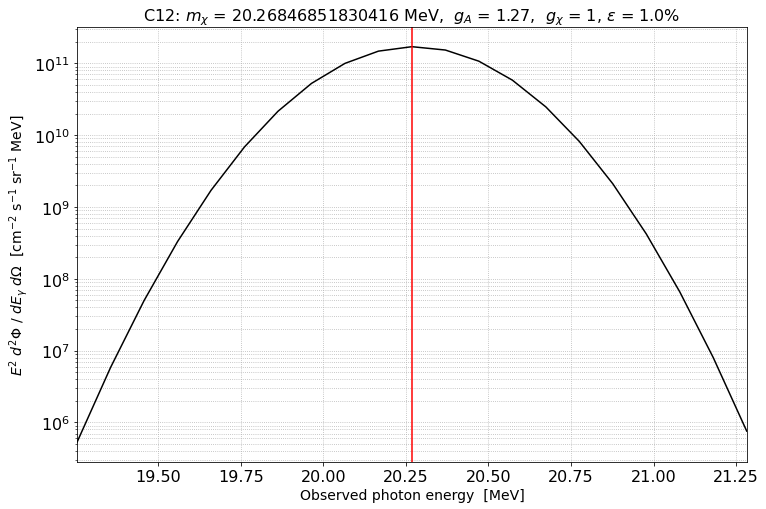

In [154]:
plotFlux(1, m_chis_C12[4], 'C12', bs[180], l_crval, 2*R_odot, 0.01, False)

In [56]:
# plotFlux(1, m_chis_C12[2], 'C12', 0, l_crval, 2*R_odot, 0.1, False)

In [57]:
# plotFlux(1, 16.731, 'O16', 0, l_crval, 2*R_odot, 0.1, False)

In [58]:
# plotFlux(1, 16.73, 'O16', 0, l_crval, 2*R_odot, 0.1, False)

In [59]:
# plotFlux(1, 16.73, 'O16', 0, l_crval, 2*R_odot, 0.01, False)

In [60]:
def flux_CO(g_chi, m_chi, b, l, R_max, epsilon):
    """
    computes CO flux - takes a few mins!
    ********
    epsilon: decimal from 0 to 1
    """
    ### !!! UPDATE ENERGY ARRAY
    energy = np.linspace((m_chi * 0.6), (m_chi * 1.4), 21)
    fluxes_C12 = []
    fluxes_O16 = []
    fluxes_CO = []
    for E in energy:
        flux_C12 = flux_wConv(g_chi, m_chi, 'C12', b, l, R_max, epsilon, E)
        flux_O16 = flux_wConv(g_chi, m_chi, 'O16', b, l, R_max, epsilon, E)
        fluxes_C12.append(flux_C12)
        fluxes_O16.append(flux_O16)
        fluxes_CO.append(flux_C12 + flux_O16)

    dat_C12 = {'Photon energy [MeV]': energy, 'C12 flux [cm^-2 s^-1 sr^-1 MeV^-1]': fluxes_C12}
    df_C12 = pd.DataFrame(dat_C12)
    df_C12.to_csv('fluxData/C12/mchi_{}MeV_b_{}deg_l_{}deg_Rmax_{}kpc_epsilon_{}.txt'.format(m_chi, b, l, R_max, 100*epsilon), sep='\t', index=False)

    dat_O16 = {'Photon energy [MeV]': energy, 'O16 flux [cm^-2 s^-1 sr^-1 MeV^-1]': fluxes_O16}
    df_O16 = pd.DataFrame(dat_O16)
    df_O16.to_csv('fluxData/O16/mchi_{}MeV_b_{}deg_l_{}deg_Rmax_{}kpc_epsilon_{}.txt'.format(m_chi, b, l, R_max, 100*epsilon), sep='\t', index=False)
    
    dat = {'Photon energy [MeV]': energy, 'CO flux [cm^-2 s^-1 sr^-2 MeV^-1]': fluxes_CO}
    df = pd.DataFrame(dat)
    df.to_csv('fluxData/CO/mchi_{}MeV_b_{}deg_l_{}deg_Rmax_{}kpc_epsilon_{}.txt'.format(m_chi, b, l, R_max, 100*epsilon), sep='\t', index=False)
    
    return fluxes_CO

    

In [61]:
# flux_CO(1, m_chis_C12[0], bs[180], l_crval, 2*R_odot, 0.01)

In [62]:
def fluxSolidAngleInt(g_chi, g_A, m_chi, nucleus, b, l, angRad, R_max, epsilon, E):
    def f(bb, ll):
        return flux_wConv(g_chi, g_A, m_chi, nucleus, bb, ll, R_max, epsilon, E)[2]
    return dblquad(f, l-angRad/2, l+angRad/2, b-angRad/2, b+angRad/2)


In [63]:
# fluxSolidAngleInt(1, 1, 'O16', 16.73, 0, l_crval+5, 5, 2*R_odot, 0.01, 16)

# coupling limits
To do (updated Nov 21):
- experiment for comparison and the direction it is pointed/solid angle integration bounds
- a list of flux values for CO
- plot $g_\chi$ vs $m_\chi$

The limit on $g_\chi$ is given by
$$ g_\chi = \sqrt{\frac{\text{experimental flux}}{\text{calculated flux}}}$$

In [64]:
def couplingLimits(fluxes, m_chis):
    """
    this function needs to:
    - import the maximum flux data point (i.e. the peak of the distribution)
    - and the associated DM mass
    - 
    """
    fC = 1e-5 # to be replaced with array of data as a function of DM mass
    fluxComps = np.ones(len(fluxes)) * fC
    g_chis = []

    for i in range(len(fluxes)):
        g_chis.append(np.sqrt(fluxComps[i] / fluxes[i]))
    

# test & other functions used along the way

## finding optimum $m_\chi$ values

Results for the optimal values of $m_\chi$ can be found in the 'optimal_m_chis_{}.txt' files.
The functions below do not need to be run, but are included here for posterity.

Based on testing, the optimal values of $m_\chi$ are not affected by the choice of $r$, HOWEVER, $r$ is used in the $v_N$ integral to find $v_\text{esc}(r)$ and the normalization factor, so with the current error in normalization at low $r$ there would theoretically be a difference. Currently the optimal values of $m_\chi$ are being calculated at a value of $r$ not impacted by the normalization error.

In [65]:
def negInt_v_N(m_chi, m_N, deltaE, r):
    return np.negative(Int_v_N(m_chi, m_N, deltaE, r))

def minimizeInt_v_N(nucleus, deltaE, r):
    # m_chi_initialGuess = 16#np.arange(deltaE - 1/10, deltaE, 1e-2)
    # print(m_chi_initialGuess)
    res = minimize_scalar(negInt_v_N, bounds=(deltaE-1/10, deltaE), \
                   args=(nuc_info[nucleus][0], deltaE, r))
    return(res.x)

# np.negative(Int_v_N(m_chi = 16.73, m_N = nuc_info['O16'][0], deltaE = 16.732241, r = 10))
# minimizeInt_v_N('O16', 16.732240999999995, 10)


In [66]:
def optimal_m_chis(r):
    """
    creates .txt files of optimal m_chis for all C12, O16 excitation energies (files have already been generated, no need to run function)
    """
    nuclei = {'C12': CdEs, 'O16': OdEs}
    for i in ['C12', 'O16']:
        m_chis = []
        all_dEs = []
        for dE in nuclei[i]:
            all_dEs.append(dE)
            m_chis.append(minimize_Int_v_N(i, dE, r))
        dat = {'Nuclear excitation energy [MeV]': all_dEs, 'Optimal DM mass [MeV]': m_chis}
        df = pd.DataFrame(dat)
        df.to_csv('optimal_m_chis_{}.txt'.format(i), sep='\t', index=False)
    return


In [67]:
Int_v_N(m_chi = 16.72, m_N = nuc_info['O16'][0], deltaE = 16.732240999999995, r = 10)

5.1543024206501824e-61

In [68]:
negInt_v_N(m_chi = 16.72, m_N = nuc_info['O16'][0], deltaE = 16.732240999999995, r = 10)


-5.1543024206501824e-61

In [69]:
negInt_v_N(m_chi = 16.73, m_N = nuc_info['O16'][0], deltaE = 16.732240999999995, r = 10)


-5.272495518918402e-11

In [70]:
negInt_v_N(m_chi = 16.722240999999993, m_N = nuc_info['O16'][0], deltaE = 16.732240999999995, r = 10)


-5.030229822733859e-38

In [71]:
negInt_v_N(m_chi = 16.728184508712996, m_N = nuc_info['O16'][0], deltaE = 16.732240999999995, r = 10)


-0.0006394724743537546

## test: $m_\chi$ vs $\int d^3 v_N$
Seeing the where the $v_N$ integral is maximized.

16.726977842105256


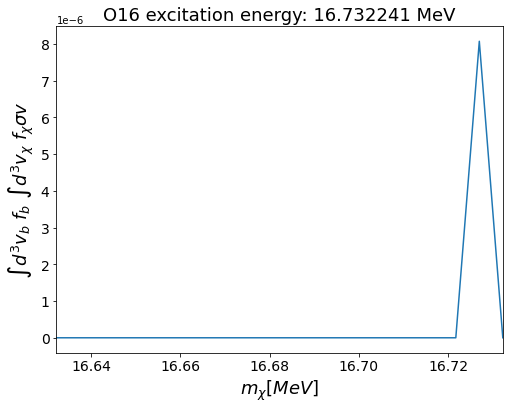

In [72]:
def Int_v_N_plot(DeltaE):
    Int_v_N_list = []
    m_chi_list = np.linspace(DeltaE - 0.1, DeltaE, 20)
    for i in m_chi_list:
        Int_v_N_list.append(Int_v_N(m_chi = i, m_N = nuc_info['O16'][0], deltaE = DeltaE, r = 3))
    plt.figure(figsize = (8, 6))
    plt.xlabel(r'$m_\chi [MeV]$', fontsize = 18); plt.ylabel(r'$\int d^3 v_b ~f_b ~\int d^3 v_\chi ~f_\chi \sigma v$', fontsize = 18)
    plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)
    plt.xlim(m_chi_list[0], m_chi_list[-1])
    plt.plot(m_chi_list, Int_v_N_list)
    plt.title("O16 excitation energy: {:2.6f} MeV".format(DeltaE), fontsize = 18)
    print(m_chi_list[Int_v_N_list.index(max(Int_v_N_list))])

Int_v_N_plot(OdEs[4])


In [73]:
def v_b_test(nucleus, m_chi, deltaE, r):
    # testing to make sure a velocity in the (v_N_min, v_N_max) range returns a nonzero answer
    m_N = nuc_info[nucleus][0]
    V_ESC = v_esc(r)
    v_N_minMax = v_N_integralBounds(m_N, m_chi, deltaE, V_ESC) # [km/s]
    print((v_N_minMax[1] + v_N_minMax[0])/2)
    return Int_v_chi(m_chi, m_N, deltaE, r, (v_N_minMax[1] + v_N_minMax[0])/2)
                     #m_N, m_chi, deltaE, s, b, l, (v_N_minMax[1] - v_N_minMax[0])/2)

v_b_test('O16', 16.73, 16.732241, 8)
# v_N_integralBounds(m_N = nuc_info['O16'][0], m_chi = 16.72, deltaE = 16.732241)

162.50747678926388


9.149786243147542

## test: distribution functions

The distribution functions are normalized such that
\begin{align}
1 &= \int_0^{v_\text{esc}} f(v) d^3 v \\
&= \int_0^{2\pi} d\phi \int_0^\pi d\theta ~\sin\theta \int_0^{v_\text{esc}(r)} dv ~v^2 f(\vec{v})
\end{align}

For the baryon distribution **(note that the baryon velocity dispersion currently does NOT depend on radius)**,
\begin{equation}
f_b(v_b) = \frac{1}{\mathcal{N}_b(r)} \left( \frac{1}{2\pi \sigma_b^2} \right)^{3/2} \exp\left[ -\frac{\left( \vec{v}_b - \bar{v}(r) \right)^2}{2\sigma_b^2} \right]
\end{equation}

The integral gives analytic solution
\begin{align}
\mathcal{N}_b(r) &= 4\pi \left[ 2\pi \sigma_b^2 \right]^{-3/2} \frac{1}{2} \sigma_b \\
& \qquad \times \Bigg( \sqrt{2\pi}\left(\bar{v}(r)^2 + \sigma_b^2\right) ~\text{erf}\left[ \frac{\bar{v}(r)}{\sqrt{2} \sigma_b} \right] - \sqrt{2\pi}\left( \bar{v}(r)^2 + \sigma_b^2 \right) ~\text{erf} \left[ \frac{\bar{v}(r) - v_\text{esc}(r)}{\sqrt{2} \sigma_b} \right] \\
& \qquad \qquad + 2\bar{v}(r) \sigma_b \exp\left[-\frac{\bar{v}(r)^2}{2\sigma_b^2} \right] - 2\sigma_b(r) \left(\bar{v}(r) + v_\text{esc}(r) \right)\exp\left[-\frac{\left(\bar{v}(r) - v_\text{esc}(r)\right)^2}{2 \sigma_b^2} \right]\Bigg)
\end{align}

For the DM distribution,
\begin{equation}
f_\chi(\vec{v}_\chi) = \frac{1}{\mathcal{N}_\chi(r)} \left( \frac{1}{2\pi (\sigma_\chi(r))^2} \right)^{3/2} \exp\left[ -\frac{\vec{v}_\chi^2}{2(\sigma_\chi(r))^2} \right]
\end{equation}

The integral gives analytic solution
\begin{align}
\mathcal{N}_\chi(r) &= 4\pi \left[ 2\pi (\sigma_b(r))^2 \right]^{-3/2} \times \Bigg( \sqrt{\frac{\pi}{2}}  (\sigma_\chi(r))^3 ~\text{erf}\left[ \frac{v_\text{esc}(r)}{\sqrt{2} \sigma_\chi(r)} \right] - (\sigma_\chi(r))^2 v_\text{esc}(r) \exp\left[ \frac{-(v_\text{esc}(r))^2}{2(\sigma_\chi(r))^2} \right] \Bigg)
\end{align}

In [74]:
def Int_f_chi(r, b, l):
    """
    integrated DM velocity distribution function - used to check normalization factor
    """
    V_ESC = v_esc(r) # [km/s]
    sigma_chi = vDispersion(r)[1] # [km/s]
    norm = norm_chi(V_ESC, sigma_chi)
    if norm<0:
        return 0
    def f(v_chi):
        return 1/norm * (2*np.pi * sigma_chi**2)**(-3/2) * v_chi**2 * np.exp(-v_chi**2 / (2 * sigma_chi**2))
    integral = 4 * np.pi * quad(f, 0, V_ESC)[0] # [unitless]
    
    return integral


def Int_f_b(r, b, l):
    """
    integrated baryon velocity distribution function - used to check normalization factor
    """
    VBAR = vbar # [km/s]
    # print(VBAR)
    V_ESC = v_esc(r) # [km/s]
    # print(V_ESC)
    # if V_ESC < VBAR:
    #     return 0
    sigma_b = vDispersion(r)[0] # [km/s]
    norm = norm_N(VBAR, V_ESC, sigma_b)
    if norm<0:
        # print("norm<0!")
        return 0
    
    def f(v_b):
        return 1/norm * (2*np.pi * sigma_b**2)**(-3/2) * v_b**2 * np.exp(-(v_b - VBAR)**2 / (2 * sigma_b**2))
    integral = 4 * np.pi * quad(f, 0, V_ESC)[0] # [unitless]

    return integral


def Int_f_b_noNorm(r, b, l):
    """
    integrated baryon velocity distribution function with NO NORMALIZATION
    """
    VBAR = vbar # [km/s]
    # print(VBAR)
    V_ESC = v_esc(r) # [km/s]
    # print(V_ESC)
    # if V_ESC < VBAR:
    #     return 0
    sigma_b = vDispersion(r)[0] # [km/s]
    norm = 1
    
    def f(v_b):
        return 1/norm * (2*np.pi * sigma_b**2)**(-3/2) * v_b**2 * np.exp(-(v_b - VBAR)**2 / (2 * sigma_b**2))
    integral = 4 * np.pi * quad(f, 0, V_ESC)[0] # [unitless]

    return integral


def Int_f_b_s(s, b, l):
    """
    integrated baryon velocity distribution function - used to check normalization factor
    """
    r = R(s, b, l)
    # print(r)
    VBAR = vbar
    V_ESC = v_esc(r) # [km/s]
    # if V_ESC<VBAR:
    #     return 0 # is this right?
    sigma_b = vDispersion(r)[0] # [km/s]
    norm = norm_N(VBAR, V_ESC, sigma_b)
    if norm<0:
        return 0
    
    def f(v_b):
        return 1/norm * (2*np.pi * sigma_b**2)**(-3/2) * v_b**2 * np.exp(-(v_b - VBAR)**2 / (2 * sigma_b**2))
    # print(norm)
    integral = 4 * np.pi * quad(f, 0, V_ESC)[0] # [unitless]

    return integral


In [75]:
Int_f_b_s(7, 2, l_crval)

1.0000000000000004

In [76]:
Int_f_b(3, 2, l_crval)

0.9999999999999999

In [77]:
Int_f_chi(2, 2, l_crval)

1.0

## test: normalization factor

Integral of $f_b(r)$ is not returning 1 for small radii ($r \lesssim 0.01$ kpc). From what I can tell, these are values for which the normalization factor is negative.

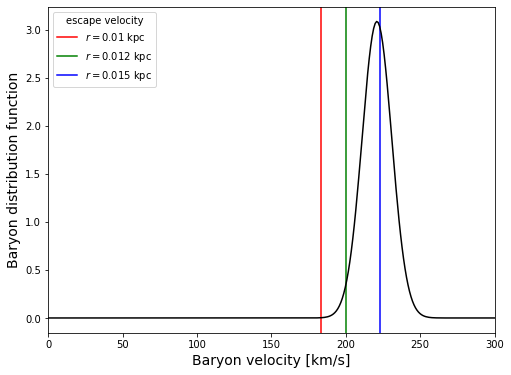

In [78]:
# plotting baryon distribution function f_b(v_b) with escape velocities for various radii
plt.figure(figsize=(8, 6))
VBAR = vbar
sigma_b = vDispersion(1)[0] # use any radius, since sigma_b is currently not a function of r
vees = np.linspace(0, 300, 300)
plt.xlim(vees[0], vees[-1])
plt.xlabel('Baryon velocity [km/s]', fontsize=14)
plt.ylabel('Baryon distribution function', fontsize=14)
plt.axvline(v_esc(0.01), label=r"$r = 0.01$ kpc", color='red')
plt.axvline(v_esc(0.012), label=r"$r = 0.012$ kpc", color='green')
plt.axvline(v_esc(0.015), label=r"$r = 0.015$ kpc", color='blue')
plt.plot(vees, (2*np.pi * sigma_b**2)**(-3/2) * vees**2 * np.exp(-(vees - VBAR)**2 / (2 * sigma_b**2)), color='black')
legend = plt.legend(loc=2)
legend.set_title(r'escape velocity')

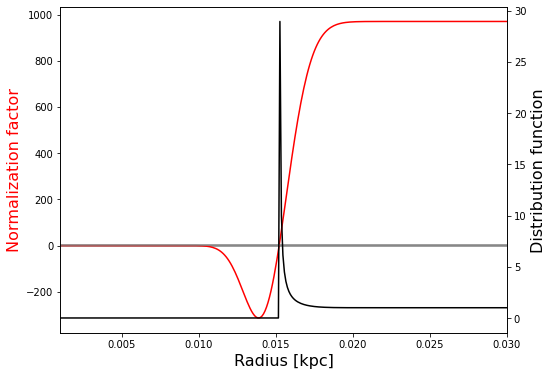

In [145]:
arrs = np.linspace(0.001,0.03, 300)
norms = list(map(lambda arr: norm_N(vbar, v_esc(arr), sigma_b), arrs))
Int_fs = list(map(lambda arr: Int_f_b(arr, 0, 0.25), arrs))

fig, ax1 = plt.subplots(figsize = (8, 6))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel(r'Radius [kpc]', fontsize = 16)
ax1.set_ylabel(r'Normalization factor', fontsize = 16, color='red')
ax2.set_ylabel(r'Distribution function', fontsize = 16)  # we already handled the x-label with ax1
ax2.set_xlim(arrs[0], arrs[-1])
ax1.plot(arrs, np.zeros(len(arrs)), color='grey')
ax1.plot(arrs, norms, label="Normalization".format(bb, ll), color='red')
ax2.plot(arrs, Int_fs, label = 'Distribution function', color='black')
ax1.plot(arrs, np.ones(len(arrs)), color='grey')
# ax1.legend()
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.title('baryon density as function of line of sight', fontsize = 24);

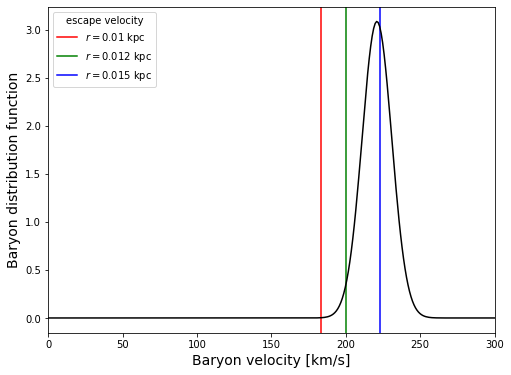

In [146]:
plt.figure(figsize=(8, 6))
VBAR = vbar
sigma_b = vDispersion(1)[0] # use any radius, since sigma_b is currently not a function of r
vees = np.linspace(0, 300, 300)
plt.xlim(vees[0], vees[-1])
plt.xlabel('Baryon velocity [km/s]', fontsize=14)
plt.ylabel('Baryon distribution function', fontsize=14)
plt.axvline(v_esc(0.01), label=r"$r = 0.01$ kpc", color='red')
plt.axvline(v_esc(0.012), label=r"$r = 0.012$ kpc", color='green')
plt.axvline(v_esc(0.015), label=r"$r = 0.015$ kpc", color='blue')
plt.plot(vees, (2*np.pi * sigma_b**2)**(-3/2) * vees**2 * np.exp(-(vees - VBAR)**2 / (2 * sigma_b**2)), color='black')
legend = plt.legend(loc=2)
legend.set_title(r'escape velocity')

In [81]:
Int_fs

[0,
 0,
 0,
 1.00003533632484,
 1.0000000000000062,
 0.9999999999999959,
 1.0000000000000004,
 1.0000000000000004,
 0.9999999999999997,
 1.0000000000000009,
 1.000000000000001,
 0.9999999999999993,
 1.0000000000000002,
 0.9999999999999999,
 1.0000000000000002,
 0.9999999999999999,
 0.9999999999999994,
 1.0,
 1.0000000000025482,
 1.000000000000451,
 1.0000000000000484,
 1.0000000000000038,
 1.0000000000000264,
 1.0000000000000013,
 1.0,
 1.0000000000000004,
 0.9999999999999999,
 1.0,
 0.9999999999999987,
 1.0000000000000004]

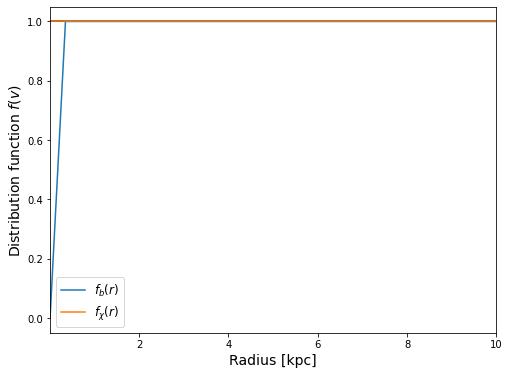

In [82]:
arrs = np.linspace(0.01,10,30)
VBAR = vbar
v_escs, sigma_bs, norm_bs, Int_f_bs, Int_f_cs = [], [], [], [], []

for i in arrs:
    V_ESC = v_esc(i)
    v_escs.append(V_ESC)
    sigma_b = vDispersion(i)[0]
    norm = norm_N(VBAR, V_ESC, sigma_b)
    norm_bs.append(norm)
    Int_f = Int_f_b(i, 0, l_crval)
    Int_f_bs.append(Int_f)
    Int_f_c = Int_f_chi(i, 0, l_crval)
    Int_f_cs.append(Int_f_c)

plt.figure(figsize=(8, 6))
plt.xlim(arrs[0], arrs[-1])
# plt.ylim(0,2); plt.yscale('log')
plt.xlabel('Radius [kpc]', fontsize=14)
plt.ylabel(r'Distribution function $f(v)$', fontsize=14)
plt.plot(arrs, np.ones(len(arrs)), color='black')
plt.plot(arrs, Int_f_bs, label=r'$f_b(r)$')
plt.plot(arrs, Int_f_cs, label=r'$f_\chi(r)$')
plt.legend(fontsize=12)

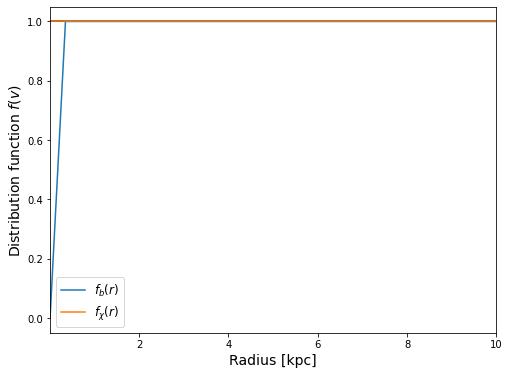

In [83]:
arrs = np.linspace(0.01,10,30)
VBAR = vbar
v_escs, sigma_bs, norm_bs, Int_f_bs, Int_f_cs = [], [], [], [], []

for i in arrs:
    V_ESC = v_esc(i)
    v_escs.append(V_ESC)
    sigma_b = vDispersion(i)[0]
    norm = norm_N(VBAR, V_ESC, sigma_b)
    norm_bs.append(norm)
    Int_f = Int_f_b(i, 0, l_crval)
    Int_f_bs.append(Int_f)
    Int_f_c = Int_f_chi(i, 0, l_crval)
    Int_f_cs.append(Int_f_c)
    
plt.figure(figsize=(8, 6))
plt.xlim(arrs[0], arrs[-1])
# plt.ylim(0,2)
# plt.yscale('log')
plt.xlabel('Radius [kpc]', fontsize=14)
plt.ylabel(r'Distribution function $f(v)$', fontsize=14)
plt.plot(arrs, np.ones(len(arrs)), color='black')
plt.plot(arrs, Int_f_bs, label=r'$f_b(r)$')
plt.plot(arrs, Int_f_cs, label=r'$f_\chi(r)$')
plt.legend(fontsize=12)
# f_bs


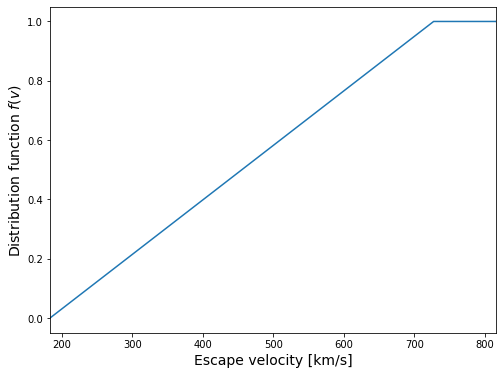

In [246]:
plt.figure(figsize=(8, 6))
plt.xlabel('Escape velocity [km/s]', fontsize=14)
plt.ylabel(r'Distribution function $f(v)$', fontsize=14)
plt.xlim(v_escs[0], v_escs[-1])
plt.plot(v_escs, Int_f_bs)
# plt.legend(fontsize=12)


## test: Effective baryon-DM J-factor

In [85]:
def Jfactor_chi(b, l):
    # https://arxiv.org/pdf/1012.4515.pdf
    r_odot = R_odot # 8.33 # [kpc] pg 33
    rho_odot = rho_s # 0.3 # [GeV/cm^3] pg 33

    def f(s):
        r = R(s, b, l)
        rho_chi = density('C12', r, b, l)[1] # [GeV/cm^3]
        integrand = (1/r_odot) * rho_chi / rho_odot
        return integrand

    return quad(f, 0, 10)[0] # [km^3 s^-3 MeV^-2]


def Jfactor_b(b, l):
    # https://arxiv.org/pdf/1012.4515.pdf
    r_odot = R_odot # 8.33 # [kpc] pg 33
    rho_odot = rho_s # 0.3 # [GeV/cm^3] pg 33

    def f(s):
        r = R(s, b, l)
        rho_b = density('C12', r, b, l)[0] # [GeV/cm^3]
        integrand = (1/r_odot) * rho_b / rho_odot
        return integrand

    return quad(f, 0, 10, limit=100)[0] # [km^3 s^-3 MeV^-2]


def plotEffectiveJfactorDensityComponents():
    """
    Plots the baryon and DM density components of the "effective baryon-DM J-factor" separately to see their individual behaviour.
    """
    b = 0
    plt.figure(figsize = (12, 8))
    plt.xlabel(r'$\psi$ [degrees]', fontsize = 16)
    plt.ylabel(r'$J(\psi)$', fontsize = 16)
    plt.xlim(0, 180)
    ells_b = np.linspace(l_crval, ls[-1], 20)
    ells = np.linspace(l_crval, ls[-1], 100)
    Jfactors_chi = list(map(lambda ell: Jfactor_chi(b, ell), ells))
    Jfactors_b = list(map(lambda ell: Jfactor_b(b, ell), ells_b))
    plt.yscale('log')
    plt.plot(ells, Jfactors_chi, label=r'$\chi$')
    plt.plot(ells_b, Jfactors_b, label = r'b')
    plt.legend(fontsize = 16)
    plt.title('Effective baryon-DM J-factor density components', fontsize=20);
    # plt.savefig('effectiveJ-factorDensityComponents.pdf')
    return

# plotEffectiveJfactorDensityComponents()

In [86]:
def Jfactor_chi_b(b, l):
    S_MAX = s_max(b, l, 2 * R_odot) # [kpc]
    rho_chi_odot = 0.3 # [GeV/cm^3]
    rho_b_odot = 2 # [GeV/cm^3] approximate average value chosen from baryon density plot above
    r_odot = R_odot
    
    def f(s):
        r = R(s, b, l)
        DM_integral = Int_f_chi(s, b, l) # [unitless]
        baryon_integral = Int_f_b(s, b, l) # [unitless]
        rho = density('O16', r, b, l) # [GeV/cm^3]
        rho_b, rho_chi = rho[0], rho[1] # [GeV/cm^3], [GeV/cm^3]
        integrand = rho_chi / rho_chi_odot * DM_integral * rho_b / rho_b_odot * baryon_integral # [unitless]
        return integrand
    return 1/r_odot * quad(f, 0, S_MAX, limit=100)[0] # [unitless]


def plotEffectiveJfactor():
    """
    Plots an "effective baryon-DM J factor" of baryon densty times DM density.
    """
    ells = np.linspace(l_crval, ls[-1], 100)
    J_factor_list = []
    for i in ells:
        J_factor_list.append(Jfactor_chi_b(0.25, i))
    plt.figure(figsize = (12, 8))
    plt.xlabel(r'$\psi$ [degrees]', fontsize = 16); plt.ylabel(r'$J(\psi)$', fontsize = 16)
    plt.xlim(0, 180)
    plt.yscale('log')
    plt.plot(ells, J_factor_list, label = r'$b \approx 0, \psi \approx l$')
    plt.title('Effective baryon-DM J-factor', fontsize=20);
    # plt.savefig('effectiveBaryonDMJ-factor.pdf')
    return

# plotEffectiveJfactor() # takes a long time to run

## test: normalization of $dN/dE_\gamma$

In [87]:
def dNdE_gamma(g_chi, g_A, nucleus):
    """
    returns: sum of dNdgamma weighted by their GT strengths (should equal 1)
    **********
    g_chi: [MeV^-1]
    g_A: axial form factor [unitless]
    """
    nuc_info = {'He4': [3758.26, 0.0], 'C12': [11274.78, 0.0], 'N14': [13153.91, 0.0], 'O16': [15033.04, 0.0]}
    m_N, J_N = nuc_info[nucleus][0], nuc_info[nucleus][1]
    dEs, GTs = dEs_dict[nucleus], GTs_dict[nucleus]
    nucl_exc = zip(dEs, GTs)
    GT_sum = np.sum(GTs)
    dNdgamma = 0

    for dE, GT in nucl_exc:
        dNdgamma += GT / GT_sum # branching ratio, [unitless]

    return dNdgamma # [cm^-2 s^-1 MeV^-1]

dNdE_gamma(1, 1, 'O16')

1.0000000000000002